# Score Functions, Calibration, and Fairness

Decision making systems, and binary classification problems in particular, often involve developing an intermediate score function. A *score* function is a real-valued function that summarizes the data in a natural way for making a (yes/no) decision. Such a function becomes a classifier by *thresholding* the score. 

A common score function is one that summarizes the data such that the output representing the probability that an event of interest occurs. A threshold for deciding such a decision is often set at 0.5.

**Score function: logistic regression**. Logistic regression considers a linear relationship between:
* predictor variables $X$,
* the log-odds of the event $Y = 1$ occurring.
This results in a score function that estimates the probability of $Y = 1$:

$$
p(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}
$$

One can derive a classifier by thresholding this score at 0.5: 

$$
C(x) = \left\{\begin{matrix}
0 {\rm\ if\ } p < 0.5 \\ 
1 {\rm\ if\ } p \geq 0.5 \\ 
\end{matrix}\right.
$$

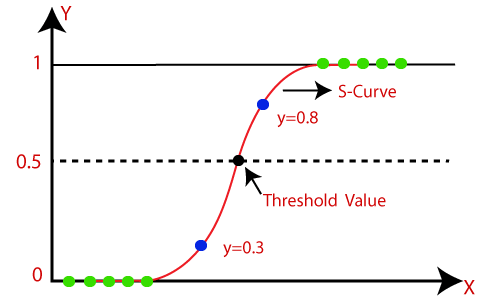

**Conditional Expectation** Given historical data, the conditional expectation defines a natural scoring function: it's exactly the expectation of the outcome, given what's historically been observed. The formula for the score is:

$$
S(x) = E[Y | X = x]
$$

This function is essentially a 'look-up table' of joint empirical probabilities; given an occurrence $X$, look up the average outcome of similar occurrences. 

Note: if $Y$ is binary, this is interpretable as a 'best guess' probability.

## From Scores to Classifiers

Given a score function $S$ define a classifier $C_t$ by thresholding at $t$:

$$
C_t(x) = \left\{\begin{matrix}
0 {\rm\ if\ } S(x) < t \\ 
1 {\rm\ if\ } S(x) \geq t \\ 
\end{matrix}\right.
$$

How do you choose $t$?

If $S$ represents a probability, then $t$ represents how confident for $C_t$ to make a certain decision. This generally depends on the utility of the context. How expensive is the cost for accepting a negative (FP)? for rejecting a positive (FP)? Choosing such a threshold is called choosing an "operating point".

The ROC Curve ("Receiver Operating Characteristic") captures the trade-off between choice of threshold $t$ for $S$ and the resulting TPR/FPR for $C_t$. It is a curve parameterized by $t$: every choice of threshold results in a classifier with a possibly different TPR/FPR, which is a point on the ROC curve.

For example, choosing
* the threshold $t = max_x{S(x)}$, results in a classifier $C_t$ that always predicts 0. The TPR is therefore 0 and the FPR 0. This is the point at the origin.
* the threshold $t = min_x{S(x)}$, results in a classifier $C_t$ that always predicts 1. The TPR is therefore 1 and the FPR 1. This is the point at $(1,1)$.
* Intermediate thresholds yield classifiers with $(TPR, FPR)$ in the unit square.

The more of the curve near (0,1), the better classifiers $C_t$ the score function $S$ creates, as seen in the graph below.

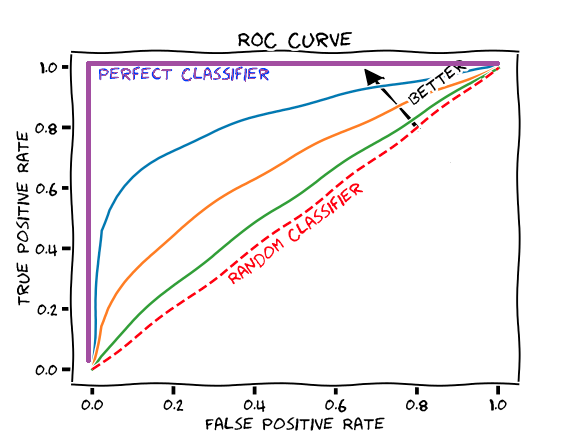

The *Area Under the Curve* (AUC) represents how predictive the score function is along all possible thresholds.

How does a data scientist choose the best threshold? Typically, one chooses a threshold from a score function by 
* Measuring the utility of FN/FP and choosing a classifier that realizes the desired balance between them.
* Choosing the classifier of highest accuracy (if FP and FN are similar cost).


## Fairness of a Score Function

One can ask whether a score function satisfies similar notions to the parity conditions from previous lectures. We take two approaches:
1. Can construct a classifier from the score function that satisfies given parity conditions?
2. Does the distribution of scores themselves satisfy parity, in some sense?

These approaches are useful, as they point to ways of building a fair classifier from one that's unfair via post-processing (changing a threshold doesn't require knowing anything about the model). 

We will approach this post-processing by using *derived classfiers* $Y = F(S, A)$ that result from applying a function to the score function $S$. For example:
* $F$ may choose different thresholds $t$ for individuals in different groups $a,b\in A$.
* $F$ may apply some randomization procedure for deciding which prediction to use from an underlying set of thresholds.

### Equalized Odds

Given a score function $S$, how can we choose a threshold $t$ so $C_t$ satisfies equalized odds? Recall that Equalized Odds requires parity of FNR/FPR across groups. If one considers the score function $S$ restricted to the two groups separately $S|a$, $S|b$, then we can plot the ROC curve for each score function:

![](https://fairmlbook.org/assets/roc_curve_2.svg)
(Figure from {cite}`barocas-hardt-narayanan`)

The point of intersection of the two ROC curves represents classifiers for the two groups that satisfies Equality of Odds (since FNR = 1 - TPR). However, these classifiers may have different thresholds. A single classifier satisfying Equality of Odds is obtained via a two-threshold derived classifier:

$$
F(x, c) = \left\{\begin{matrix}
0 {\rm\ if\ } (S|_a(x) < t_a) {\rm\ and\ } c = a \\
0 {\rm\ if\ } (S|_b(x) < t_b) {\rm\ and\ } c = b \\ 
1 {\rm\ if\ } (S|_a(x) \geq t_a  {\rm\ and\ } c = a\\ 
1 {\rm\ if\ } (S|_b(x) \geq t_b)  {\rm\ and\ } c = b \\ 
\end{matrix}\right.
$$

Where $t_a, t_b$ are the thresholds where the two curves intersect.

What if the two ROC curves don't intersect? Or if you have specific requirements for FPR and TPR from the model? You can choose a model from any point *under* both of the ROC curves. 

If two classifiers $C_a, C_b$ are chosen from the ROC curves of groups $a,b$ respectively, then all classifiers on the line joining $C_a$ and $C_b$ are realized by:

$$
C(x) = \left\{\begin{matrix}
C_a(x) {\rm\ choose\ with\ probability\ } p \\
C_b(x) {\rm\ choose\ with\ probability\ } (1 - p) \\
\end{matrix}\right.
$$

Where $0 \leq p \leq 1$. Note that a classifier *under* the ROC curve will sacrifice utility: the TPR/FPR are lower than optimal.

### Calibration

Recall that Predictive Value Parity states, for all $a,b$ in $A$:

$$
P(Y = 1|C = 1, A = a) = P(Y = 1| C = 1, B = b) \\
P(Y = 1|C = 0, A = a) = P(Y = 1| C = 0, B = b)
$$

This is a special case, for binary classifiers of the condition "the true outcome $Y$ is independent of $A$, conditional on the prediction $C$. This notion is related to a concept called *calibration*.

A score function $S$ is *calibrated* if for all scores $s$,

$$
P(Y = 1|S = s) = s
$$

When $S$ is interpretable as a probability, this means that the positive proportion of all individuals given score $s$ should itself be $s$. For example, if the COMPAS score is calibrated, then among the defendants receiving the (lowest) risk score of 0.1, those that re-offended make up only 10% of that group. Similarly, those among the (highest) risk score 0.9 should consist mostly (90%) of those that actually did re-offend.

*Note:* An arbitrary score function can be calibrated via applying a scaling procedure called Platt scaling.

### Calibration within Groups

One notion of fairness for a score function is *calibrations within groups*:

$$
P(Y = 1| S = s, A = a) = s, \quad {\rm for\ all\ } s\in\mathbb{R}, a\in A
$$

Calibration requires similar scores to be meaningful. Calibration within groups requires similar scores be meaningful across groups as well. Calibration within groups for a score function implies that all induced classifiers satisfy predictive value parity.

### Balance for the Postive/Negative Class

Another notion of fairness for a score function is *balance for the positive (or negative) class*. This requires the average score of those who belong to the positive (negative) class be the same across groups:

$$
E[S|Y=1, A=a] = E[S|Y = 1, A = b]
$$

The condition is analogous for the negative class.

Balance for the positive/negative class is a continuous version of Equalized Odds. Indeed, it requires similar predictions for those with similar *true* behavior, across groups.

## Trade-Offs for Score Functions

An analogous version for score functions of the trade-offs theorem is found in {cite}`kleinberg2016inherent`.

Suppose a score function S satisfies the following three conditions:
* Calibration from within groups
* Balance for the positive class
* Balance for the negative class.

Then 
* the score function must define a perfect predictor, or
* the groups have equal base-rates

This theorem is stronger than the trade-offs theorem for classifiers. One the one hand, score functions define many potential classifiers; this theorem makes a statement about all of these at once. On the other hand, the theorem also has an *approximate* version:
* The further the base-rates are from equal, the more severe the failure of at least one of the conditions.
* The further the classifier is from perfect, the more severe the failure of at least one of the conditions.

For proofs of these observations, see {cite}`kleinberg2016inherent`.
